In [1]:
import numpy as np
import sys
import time
# importing S4
sys.path.append('/home/pellegr/electrodynamics/st-matrix/S4/build/lib.linux-x86_64-2.7')
import S4
# importing py-matrix parent folder
sys.path.append('/home/pellegr/electrodynamics/st-matrix')
sys.path.append('/home/pellegr/electrodynamics/st-matrix/mans/')
import py_matrix as pm
import seaborn as sns

# multiprocessing
from multiprocessing import cpu_count
from joblib import Parallel, delayed
num_cores=cpu_count()/2

In [2]:
# linking diagnostics
from distutils import sysconfig
print 'LDSHARED',sysconfig.get_config_var('LDSHARED')
print 'CC',sysconfig.get_config_var('CC')
print 'CFLAGS',sysconfig.get_config_var('CFLAGS')
print 'LDFLAGS',sysconfig.get_config_var('LDFLAGS')

LDSHARED gcc -pthread -shared
CC gcc -pthread
CFLAGS -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes
LDFLAGS 


## inputs

In [3]:
#------building the optical constant database------
eps_db_out=pm.mat.generate_eps_db('/home/pellegr/electrodynamics/st-matrix/py_matrix/materials/',ext='*.edb')
eps_files,eps_names,eps_db=eps_db_out['eps_files'],eps_db_out['eps_names'],eps_db_out['eps_db']

In [4]:
T_raw=np.loadtxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/Transmittance.dat',skiprows=2)
R_raw=np.loadtxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/Reflectance.dat',skiprows=3)
A_raw=np.loadtxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/Absorbance.dat',skiprows=3)

In [5]:
# stack material an thicknesses
stack=['e_vacuum','e_au','e_sio2'];
d_list=[0.0,50.0,0.0];

# incident angles
theta_0=0.0
phi_0=0.0

# wavelengths
v_wl=np.linspace(400,1200,4*num_cores)

# nanohole array r and pitch in nm
nh_p=535
nh_r=100


# conversion factor
cf=1e-3

## S4 Solution

In [6]:
S=S4.New(Lattice=((nh_p*cf,0),(nh_p*cf*np.cos(np.pi/3.0),nh_p*cf*np.sin(np.pi/3.0))), NumBasis=100)
#S=S4.New(Lattice=((nh_p*cf,0),(0,nh_p*cf)), NumBasis=100)

# retrieving optical constants at wl from the database
e_list=np.array(pm.mat.db_to_eps(v_wl[0],eps_db,stack))

S.SetMaterial('Air',e_list[0])
S.SetMaterial('Au',e_list[1])
S.SetMaterial('Glass',e_list[2])
#S.SetMaterial('Glass',2.25)

S.AddLayer('Inc',d_list[0]*cf,'Air')

S.AddLayer('Slab',d_list[1]*cf,'Au')
S.SetRegionCircle('Slab', 'Air', (0.0,0.0), nh_r*cf)

S.AddLayer('Sub',d_list[2]*cf,'Glass')

S.SetExcitationPlanewave((theta_0,phi_0),1.0,0.0)
S.SetOptions(PolarizationDecomposition = True,PolarizationBasis='Jones')

In [ ]:
def fluxes(wl):
    # retrieving optical constants at wl from the database
    e_list=np.array(pm.mat.db_to_eps(wl,eps_db,stack))

    S.SetMaterial('Air',e_list[0])
    S.SetMaterial('Au',e_list[1])
    S.SetMaterial('Glass',e_list[2])

    S.SetFrequency(1.0/(wl*cf))
    forw_1,back_1 = S.GetPowerFlux(Layer = 'Inc', zOffset = 0)
    forw_2,back_2 = S.GetPowerFlux(Layer = 'Sub', zOffset = 0)

    return forw_1,back_1,forw_2,back_2

In [ ]:
%%time
v_numbasis=[50,100,150,200,250,300,350,400,450,500]

out=[]
for num in v_numbasis:
    tic=time.time()
    S=S4.New(Lattice=((nh_p*cf,0),(nh_p*cf*np.cos(np.pi/3.0),nh_p*cf*np.sin(np.pi/3.0))), NumBasis=num)

    # retrieving optical constants at wl from the database
    e_list=np.array(pm.mat.db_to_eps(v_wl[0],eps_db,stack))

    # materials
    S.SetMaterial('Air',e_list[0])
    S.SetMaterial('Au',e_list[1])
    S.SetMaterial('Glass',e_list[2])

    # layers
    S.AddLayer('Inc',d_list[0]*cf,'Air') # 1
    S.AddLayer('Slab',d_list[1]*cf,'Au') # 2
    S.SetRegionCircle('Slab', 'Air', (0.0,0.0), nh_r*cf)
    S.AddLayer('Sub',d_list[2]*cf,'Glass') # 3

    # incident wave
    S.SetExcitationPlanewave((theta_0,phi_0),1.0,0.0)

    # options
    S.SetOptions(PolarizationDecomposition = True,PolarizationBasis='Jones')

    # computation
    result=Parallel(n_jobs=num_cores)(delayed(fluxes)(wl) for wl in v_wl)
    out.append(np.array(result))
    toc=time.time()

    print "NumBasis,time",num,toc-tic

NumBasis,time 50 1.87918400764
NumBasis,time 100 12.5494639874


In [12]:
v_R_s4=[]
v_T_s4=[]
for data in np.array(out):
    
    # power fluxes
    v_fw_1=data[:,0]
    v_bw_1=data[:,1]
    v_fw_2=data[:,2]
    v_bw_2=data[:,3]
    
    # reflectance
    v_R_s4.append(-v_bw_1/v_fw_1)
    
    # transmittance
    v_T_s4.append(v_fw_2/v_fw_1)
v_R_s4,v_T_s4 = np.array(v_R_s4),np.array(v_T_s4)

In [ ]:
plt.figure(1,figsize(15,10));
index=3
plt.plot(v_wl,v_T_s4[index],'b',
         T_raw[:,0],T_raw[:,1],'b--',
         v_wl,v_R_s4[index],'k',
         R_raw[:,0],R_raw[:,1],'k--'
        );
plt.legend(('S4 T','Comsol T','S4 R','Comsol R'),fontsize=30);
plt.ylim(0.0,1.0);

In [43]:
# saving
T_data=np.real(np.vstack((v_wl,v_T_s4)).T)
R_data=np.real(np.vstack((v_wl,v_R_s4)).T)
np.savetxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/T_t50r100_planewave.txt',T_data)
np.savetxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/R_t50r100_planewave.txt',R_data)

In [95]:
v_numbasis=[50,100,150,200,250,300,350,400,450,500,1000,2000,4000]
v_x=np.linspace(-nh_p,nh_p,1000)
wl_eps=850

out_eps=[]
for num in v_numbasis:
    tic=time.time()
    S=S4.New(Lattice=((nh_p*cf,0),(nh_p*cf*np.cos(np.pi/3.0),nh_p*cf*np.sin(np.pi/3.0))), NumBasis=num)

    # retrieving optical constants at wl from the database
    e_list=np.array(pm.mat.db_to_eps(wl_eps,eps_db,stack))

    # materials
    S.SetMaterial('Air',e_list[0])
    S.SetMaterial('Au',e_list[1])
    S.SetMaterial('Glass',e_list[2])

    # layers
    S.AddLayer('Inc',d_list[0]*cf,'Air') # 1
    S.AddLayer('Slab',d_list[1]*cf,'Au') # 2
    S.SetRegionCircle('Slab', 'Air', (0.0,0.0), nh_r*cf)
    S.AddLayer('Sub',d_list[2]*cf,'Glass') # 3

    # incident wave
    S.SetExcitationPlanewave((theta_0,phi_0),1.0,0.0)

    # options
    S.SetOptions(PolarizationDecomposition = True,PolarizationBasis='Jones',SubpixelSmoothing = True)

    # computation
    result=np.array([S.GetEpsilon(x, 0.0, 0.025) for x in v_x])
    out_eps.append(result)
    toc=time.time()

    print "NumBasis,time",num,toc-tic

NumBasis,time 50 0.0251688957214
NumBasis,time 100 0.0517959594727
NumBasis,time 150 0.0782251358032
NumBasis,time 200 0.105010986328
NumBasis,time 250 0.131918907166
NumBasis,time 300 0.216414928436
NumBasis,time 350 0.462229967117
NumBasis,time 400 0.67654299736
NumBasis,time 450 0.905211925507
NumBasis,time 500 1.14326500893
NumBasis,time 1000 3.4424431324
NumBasis,time 2000 8.03142499924
NumBasis,time 4000 16.1405081749


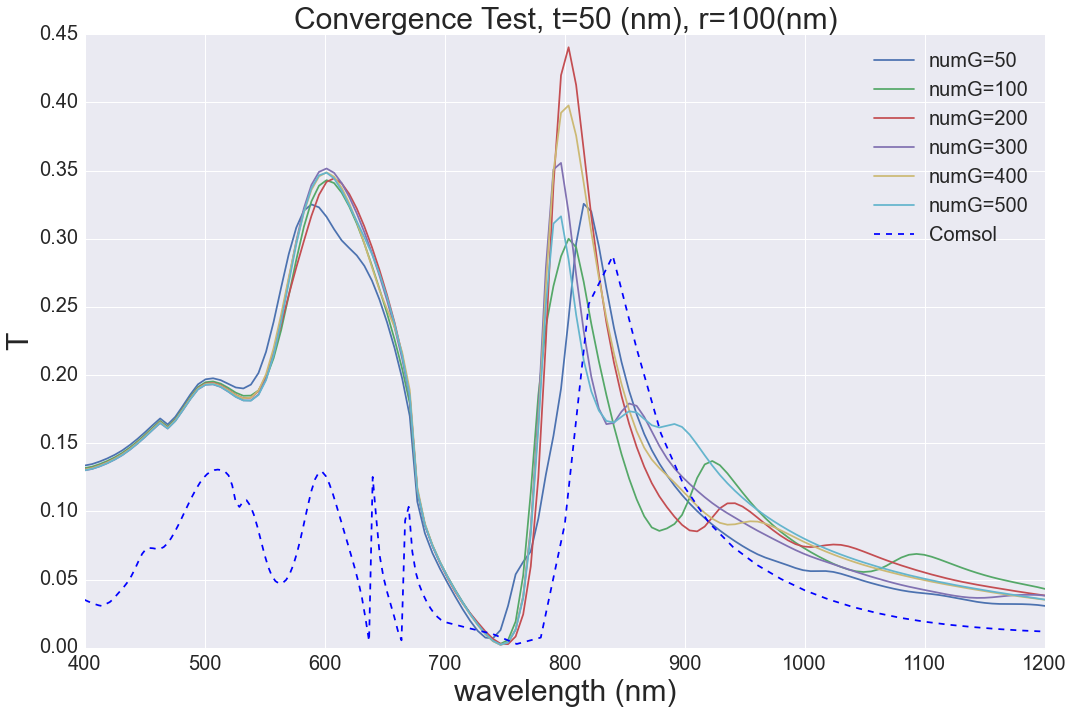

In [120]:
f_size=30;
f_size_ticks=20;
plt.figure(1,figsize(15,10));
plt.plot(v_wl,v_T_s4[0],
         v_wl,v_T_s4[1],
         v_wl,v_T_s4[3],
         v_wl,v_T_s4[5],
         v_wl,v_T_s4[7],
         v_wl,v_T_s4[9],
         T_raw[:,0],T_raw[:,1],'b--',
        );
# plt title
plt.title('Convergence Test, t=50 (nm), r=100(nm)',fontsize=f_size)

# axes labels
plt.xlabel(r'wavelength (nm)', fontsize=f_size)
plt.ylabel(r'T', fontsize=f_size)

# ticks
plt.xticks(fontsize=f_size_ticks)
plt.yticks(fontsize=f_size_ticks)

# layout
plt.tight_layout()

plt.legend(('numG=50','numG=100','numG=200','numG=300','numG=400','numG=500', 'Comsol'),fontsize=f_size_ticks);
plt.savefig('/home/pellegr/electrodynamics/st-matrix/S4/NHA/T_conv.png',bbox_inches='tight',dpi=300)

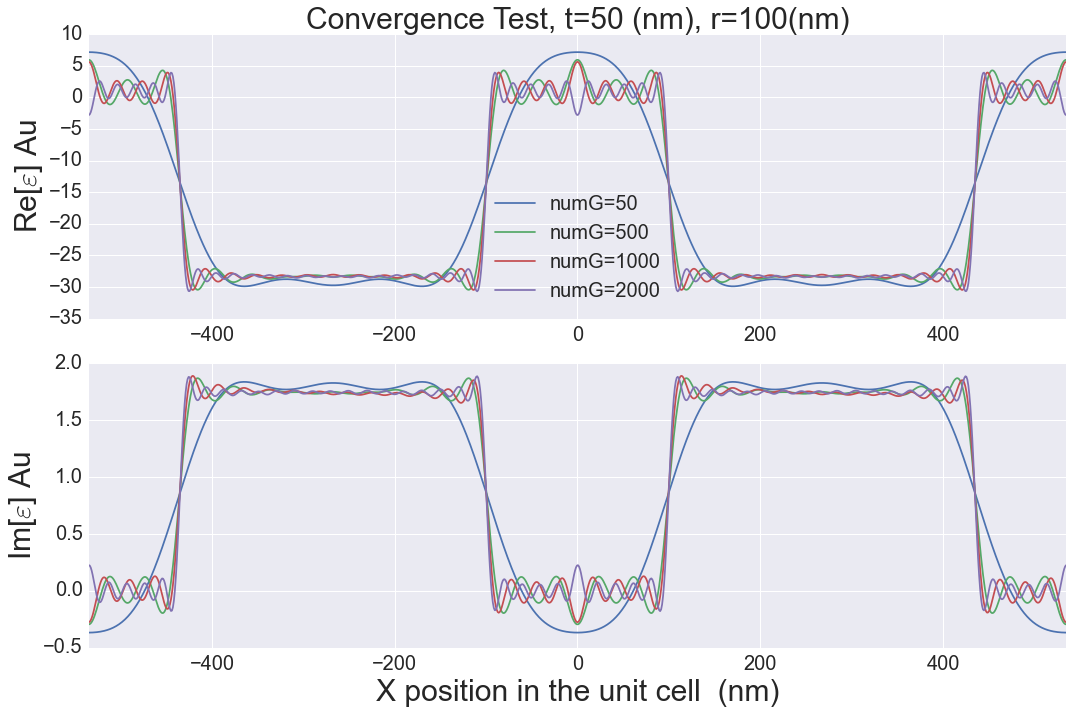

In [121]:
n=0
plt.figure(2,figsize(15,10));
plt.subplot(2,1,1)
plt.plot(v_x,out_eps[0].real,v_x,out_eps[-4].real,v_x,out_eps[-3].real,v_x,out_eps[-2].real)
plt.xlim(-nh_p,nh_p)

# plt title
plt.title('Convergence Test, t=50 (nm), r=100(nm)',fontsize=f_size)

# axes labels
plt.ylabel(r'Re[$\varepsilon$] Au', fontsize=f_size)

# ticks
plt.xticks(fontsize=f_size_ticks)
plt.yticks(fontsize=f_size_ticks)

# legend
plt.legend(('numG=50','numG=500','numG=1000','numG=2000'),fontsize=f_size_ticks,loc='lower center');

# layout
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(v_x,out_eps[0].imag,v_x,out_eps[-4].imag,v_x,out_eps[-3].imag,v_x,out_eps[-2].imag)
plt.xlim(-nh_p,nh_p)

# axes labels
plt.xlabel(r'X position in the unit cell  (nm)', fontsize=f_size)
plt.ylabel(r'Im[$\varepsilon$] Au', fontsize=f_size)

# ticks
plt.xticks(fontsize=f_size_ticks)
plt.yticks(fontsize=f_size_ticks)

# layout
plt.tight_layout()
plt.savefig('/home/pellegr/electrodynamics/st-matrix/S4/NHA/eps_conv.png',bbox_inches='tight',dpi=300)